# This Python notebook was prepared as part of Masters Science - AI/ML thesis project.
# University: John Moore Liverpool University
# Student: Vaibhav Pandey
## Submission: Nov-Dec-2022.

# At high level project compares performance of State of the Art AI/CNN and Visual Transformer models. 


### Code is taken from existing work done by researchers in scientific community, open source developers, available via GitHub. 

> ### Code is enhanced at few places to fuse model explainability, drive intuition and capture key points by: Vaibhav Pandey
> #### Disclaimer: Vaibhav Pandey do not have any copyright on the code, it is just used to demonstrate power of CNN based models with explainability methods - LIME and SHAP.
#### Code should not be used in any critical, high risk medical setting for decion making, as this may not be prooven method and has not been scrutinised.


#### Step 1: Adding Libraries and Packages for State of the Art Model.
#### Step 2: Prepare Dev environment for model replication 
#### Step 3: Inspect and Preprocess data
##### Data Type: Brain MRI Images, from opensource. 
##### Data Augmentation
#### Step 4: Model Preperation
> #### Experiment 1 - Custom Model 
> #### Experiment 2 - AlexNet Model
> #### Experiment 3 - Google's Inception Model
#### Compare methods performance. 

#####Load Tensorflow

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import *

Load General Purpose Libraries

In [5]:
import sys
import os
import math
import numpy as np
import pandas as pd
 
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline

import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
 

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import * 
from PIL import Image, ImageEnhance
 
print(f'Tensorflow Version: {tf.__version__}.')

Tensorflow Version: 2.9.2.


#####Load Tensorflow related libraries.

** **bold text**Connecting and Loading Google Drive.** 
Please note:
>1 Drive is the placeholder for our image data from brain tumor

>2  Persisting model Checkpoints


In [6]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/gdrive', force_remount=True)

# Location of Zip File
drive_path = '/gdrive/MyDrive/NN/Brain_tumour'
local_path = '/content'

Mounted at /gdrive


In [7]:
# Copy the zip file and move it up one level (AKA out of the drive folder)
!cp '{drive_path}' .a

cp: -r not specified; omitting directory '/gdrive/MyDrive/NN/Brain_tumour'


In [8]:
print({drive_path})

{'/gdrive/MyDrive/NN/Brain_tumour'}


In [9]:
print("OS Version & Details: ")
!lsb_release -a

OS Version & Details: 
No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic


**Setting up Model development, training and testing environment**

In [10]:
gpu_device_location = tpu_device_location = cpu_device_location = None
print(os.environ)

environ({'NV_LIBCUBLAS_DEV_VERSION': '11.4.1.1043-1', 'NV_CUDA_COMPAT_PACKAGE': 'cuda-compat-11-2', '__EGL_VENDOR_LIBRARY_DIRS': '/usr/lib64-nvidia:/usr/share/glvnd/egl_vendor.d/', 'NV_CUDNN_PACKAGE_DEV': 'libcudnn8-dev=8.1.1.33-1+cuda11.2', 'LD_LIBRARY_PATH': '/usr/lib64-nvidia', 'NV_LIBNCCL_DEV_PACKAGE': 'libnccl-dev=2.8.4-1+cuda11.2', 'TCLLIBPATH': '/usr/share/tcltk/tcllib1.19', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'NV_LIBNPP_DEV_PACKAGE': 'libnpp-dev-11-2=11.3.2.152-1', 'HOSTNAME': '758bea4029ba', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'KMP_EXTRA_ARGS': '--listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=https://colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/gpu-t4-s-2h22lsv5vvvvi --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_required=true', 'NV_LIBNPP_VERSION': '11.3.2.152-1', 'NV_NVPROF_DEV_PACKAGE': 'cud

In [11]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-007f683e-b9b2-d778-3038-34c1e555a2e0)


In [12]:
"""
if os.environ['COLAB_GPU'] == '1':
    print("Allocated GPU Runtime Details:")
    !nvidia-smi
    print()
    try:
        import pynvml
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        gpu_device_name = pynvml.nvmlDeviceGetName(handle)
 
        if gpu_device_name not in {b'Tesla T4', b'Tesla P4', b'Tesla P100-PCIE-16GB'}:
            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")
    except Exception as hardware_exception:
        print(hardware_exception, end = '\n\n')
    gpu_device_location = tf.test.gpu_device_name()
    print(f"{gpu_device_name.decode('utf-8')} is allocated sucessfully at location: {gpu_device_location}")
elif 'COLAB_TPU_ADDR' in os.environ:
    tpu_device_location = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
    print(f"TPU is allocated successfully at location: {tpu_device_location}.")
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_location)
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    tpu_strategy = tf.distribute.TPUStrategy()
else:
    cpu_device_location = "/cpu:0"
    print("GPUs and TPUs are not allocated successfully, hence runtime fallbacked to CPU.")
"""


'\nif os.environ[\'COLAB_GPU\'] == \'1\':\n    print("Allocated GPU Runtime Details:")\n    !nvidia-smi\n    print()\n    try:\n        import pynvml\n        pynvml.nvmlInit()\n        handle = pynvml.nvmlDeviceGetHandleByIndex(0)\n        gpu_device_name = pynvml.nvmlDeviceGetName(handle)\n \n        if gpu_device_name not in {b\'Tesla T4\', b\'Tesla P4\', b\'Tesla P100-PCIE-16GB\'}:\n            raise Exception("Unfortunately this instance does not have a T4, P4 or P100 GPU.\nSometimes Colab allocates a Tesla K80 instead of a T4, P4 or P100.\nIf you get Tesla K80 then you can factory reset your runtime to get another GPUs.")\n    except Exception as hardware_exception:\n        print(hardware_exception, end = \'\n\n\')\n    gpu_device_location = tf.test.gpu_device_name()\n    print(f"{gpu_device_name.decode(\'utf-8\')} is allocated sucessfully at location: {gpu_device_location}")\nelif \'COLAB_TPU_ADDR\' in os.environ:\n    tpu_device_location = f"grpc://{os.environ[\'COLAB_TPU_ADDR


4.1 Installation of tree Utility Using Bash.
Will be used to inspect the directory structure

In [13]:
%%bash
RED_COLOR='\033[0;31m'
NO_COLOR='\033[0m'
pkg_name=tree
dpkg -s $pkg_name &> /dev/null
if [ "$?" -ne "0" ] 
    then
        echo "Installing tree utility..."
        apt-get autoclean
        apt-get autoremove
        apt-get install $pkg_name
        if [ "$?" -eq "0" ]
            then
                echo -e ${RED_COLOR}"tree utility installed sucessfully.\n"${NO_COLOR}
        fi
    else
        echo "tree utility is already installed."
fi
tree --version

Installing tree utility...
Reading package lists...
Building dependency tree...
Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
The following packages will be REMOVED:
  libnvidia-common-460
0 upgraded, 0 newly installed, 1 to remove and 20 not upgraded.
After this operation, 35.8 kB disk space will be freed.
(Reading database ... 124013 files and directories currently installed.)
Removing libnvidia-common-460 (460.106.00-0ubuntu1) ...
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (127 kB/s)
Selecting previously unselected package tree.
(Reading database ... 124008

In [14]:
!tree -d '/gdrive/MyDrive/NN/Brain_tumour'

/gdrive/MyDrive/NN/Brain_tumour
├── Brain-Tumor-Images-Mat-Files
├── Testing
│   ├── No
│   └── Yes
├── Training
│   ├── glioma
│   ├── meningioma
│   ├── no_tumor
│   └── pituitary_tumor
└── Tumor-Mask
    ├── glioma
    ├── meningioma
    └── pituitary_tumor

13 directories


In [15]:
!tree -d "/gdrive/MyDrive/NN/Brain_tumour"

/gdrive/MyDrive/NN/Brain_tumour
├── Brain-Tumor-Images-Mat-Files
├── Testing
│   ├── No
│   └── Yes
├── Training
│   ├── glioma
│   ├── meningioma
│   ├── no_tumor
│   └── pituitary_tumor
└── Tumor-Mask
    ├── glioma
    ├── meningioma
    └── pituitary_tumor

13 directories


4.3 Setting Up Paths to Root and Data Directories


In [16]:
#Data Directories setup.
ROOT_DIR = r"/gdrive/MyDrive/NN/"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "Brain_tumour")
TRAIN_DIR = os.path.join(DATA_ROOT_DIR, 'Training')
MASK_DIR = os.path.join(DATA_ROOT_DIR, 'Tumor-Mask')

#Tumor classes 
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary_tumor', 'no_tumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
MASK_DATA_PATHS = [os.path.join(MASK_DIR, tumor_name) for tumor_name in TUMOR_CLASS[:-1]]

In [17]:
#Ensuring all paths exists
assert os.path.isdir(ROOT_DIR) 
assert os.path.isdir(DATA_ROOT_DIR) 
assert os.path.isdir(TRAIN_DIR) 
assert os.path.isdir(MASK_DIR)

In [18]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],
                                    index = TUMOR_CLASS)
data_distribution_count

meningioma          708
glioma             1426
pituitary_tumor     930
no_tumor            395
dtype: int64

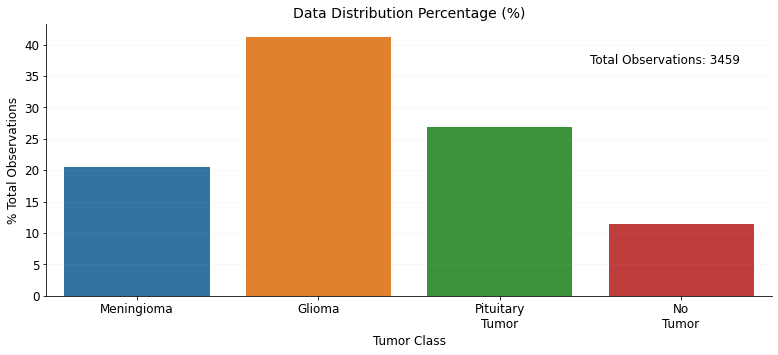

In [19]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index], 
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()


5.2 Visualisation of Brain MRI Dataset

Dataset Source: https://figshare.com/articles/dataset/brain_tumor_dataset/1512427

Source Code for Conversion of .mat file to .jpg: Google Colab Notebook Link

Final Dataset Link: https://drive.google.com/drive/folders/11QIC82FBdAyq0PUwLVNd22i-oq6lcat1?usp=sharing


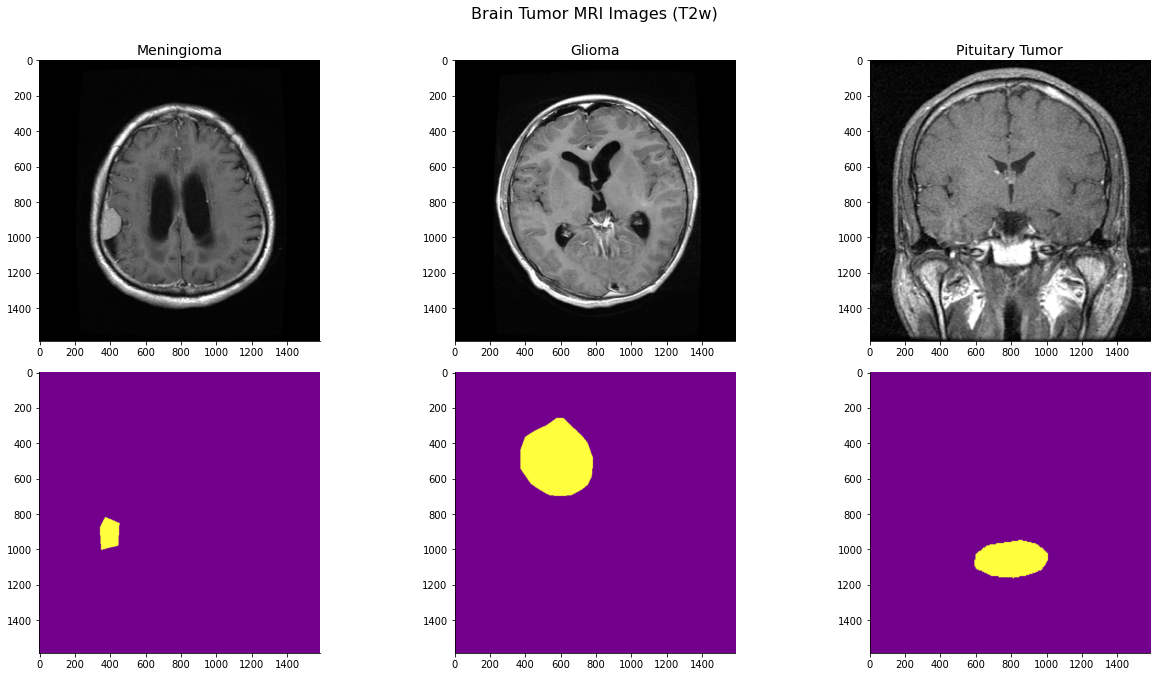

In [20]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 9))
axes = axes.flatten()
fig.suptitle("Brain Tumor MRI Images (T2w)", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS[:-1], IMAGE_DATA_PATHS[:-1], axes[:3]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)
 
for filename, curr_axis in zip(MASK_DATA_PATHS, axes[3:]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    mask_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(mask_enhancer.enhance(BRIGHTNESS_FACTOR))
fig.tight_layout()
sns.despine()


6. Development of Training, Validation & Testing Dataset


In [21]:
image_data_paths = []
for curr_path, tumor_name in zip(IMAGE_DATA_PATHS, TUMOR_CLASS):
    if os.path.exists(curr_path) and os.path.isdir(curr_path):
        image_data_paths.extend(map(lambda filename: (os.path.join(curr_path, filename), tumor_name), os.listdir(curr_path)))

In [22]:
image_data_paths_df = pd.DataFrame(image_data_paths, columns = ['image_filepaths', 'tumor_class']).sample(frac = 1, random_state = 42).reset_index(drop = True)
image_data_paths_df.head()

,image_filepaths,tumor_class
0,/gdrive/MyDrive/NN/Brain_tumour/Training/menin...,meningioma
1,/gdrive/MyDrive/NN/Brain_tumour/Training/menin...,meningioma
2,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor
3,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor
4,/gdrive/MyDrive/NN/Brain_tumour/Training/pitui...,pituitary_tumor


In [23]:
image_data_paths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_filepaths  3459 non-null   object
 1   tumor_class      3459 non-null   object
dtypes: object(2)
memory usage: 54.2+ KB


In [24]:
intermediate_train_data, test_data = train_test_split(image_data_paths_df, 
                                                      train_size = 0.70, 
                                                      random_state = 42, 
                                                      stratify = image_data_paths_df.tumor_class)
 
train_data, validation_data = train_test_split(intermediate_train_data, 
                                               train_size = 0.80, 
                                               random_state = 42, 
                                               stratify = intermediate_train_data.tumor_class)


6.1 Training, Validation and Testing Dataset Data Distribution Visualization

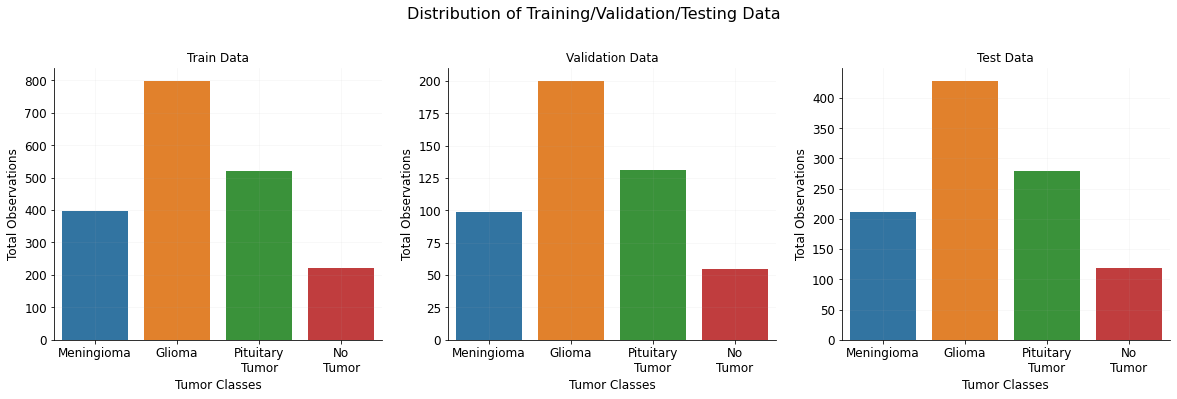

In [25]:
fig, axes = plt.subplots(ncols = 3, figsize = (20, 5))
fig.suptitle("Distribution of Training/Validation/Testing Data", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.05)
sns.countplot(x = train_data.tumor_class, order = TUMOR_CLASS, ax = axes[0])
sns.countplot(x = validation_data.tumor_class, order = TUMOR_CLASS, ax = axes[1])
sns.countplot(x = test_data.tumor_class, order = TUMOR_CLASS, ax = axes[2])
for curr_axis, curr_title in zip(axes, ['Train Data', 'Validation Data', 'Test Data']):
    curr_axis.grid(False, alpha = 0.1)
    curr_axis.set_title(curr_title, fontsize = 12)
    curr_axis.set_xlabel("Tumor Classes", fontsize = 12)
    curr_axis.set_ylabel("Total Observations", fontsize = 12)
    curr_axis.tick_params(which = 'major', labelsize = 12)
    curr_axis.set_xticklabels(["\n".join(xtick.split("_")).title() for xtick in TUMOR_CLASS])
sns.despine()



## Data/Image Augmentation
 
>    Image augmentation is usually used to increase the image dataset and also to make the network more robust against translation invariance. Image augmentation is defined as creating duplicates of the original image datasets by flipping, rotating, zooming, and adjusting brightness.

>    We will use data/image augmentation using ImageDataGenerator class to train the model on different types of combinations formed by rotation, flipping, changing the brightness etc of an image so as to increase our model accuracy.


In [26]:
image_size = 128
batch_size = 32

image_datagen_kwargs = dict(rescale = 1 / 255,
                            rotation_range = 15, 
                            width_shift_range = 0.1, 
                            zoom_range = 0.01, 
                            shear_range = 0.01,
                            brightness_range = [0.3, 1.5],
                            horizontal_flip = True,
                            vertical_flip = True)

#Image Data Generation for training, test and validations.

In [27]:
train_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
validation_image_datagen = ImageDataGenerator(**image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**image_datagen_kwargs)

In [28]:
train_dataset = train_image_datagen.flow_from_dataframe(train_data, 
                                                        x_col = 'image_filepaths', 
                                                        y_col = 'tumor_class', 
                                                        seed = 42, 
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')
validation_dataset = validation_image_datagen.flow_from_dataframe(validation_data, 
                                                                  x_col = 'image_filepaths', 
                                                                  y_col = 'tumor_class', 
                                                                  seed = 42,
                                                                  batch_size = batch_size, 
                                                                  target_size = (image_size, image_size),
                                                                  color_mode = 'rgb')
test_dataset = test_image_datagen.flow_from_dataframe(test_data, 
                                                      x_col = 'image_filepaths', 
                                                      y_col = 'tumor_class', 
                                                      seed = 42, 
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

Found 1936 validated image filenames belonging to 4 classes.
Found 485 validated image filenames belonging to 4 classes.
Found 1038 validated image filenames belonging to 4 classes.


In [29]:
print("Information about Training Dataset:")
print(train_dataset.class_indices)
print(train_dataset.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_dataset.class_indices)
print(validation_dataset.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_dataset.class_indices)
print(test_dataset.image_shape)

Information about Training Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Validation Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)

Information about Testing Dataset:
{'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
(128, 128, 3)



Visualising Images in Training datset


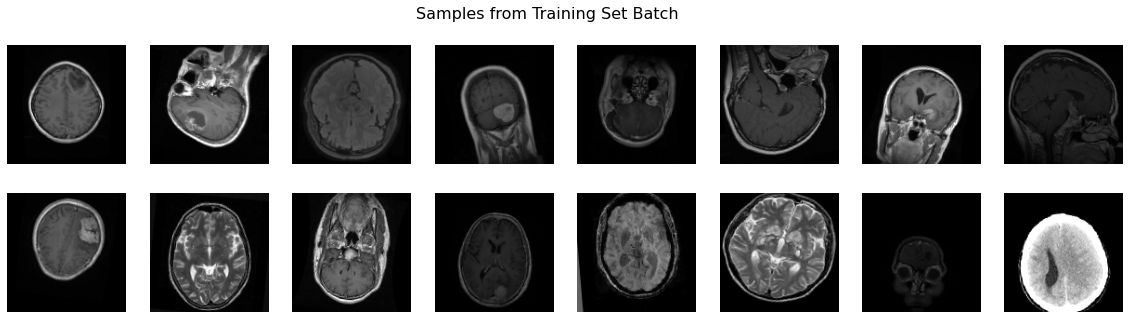

In [30]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)


7.2 Validation Data Images Glimpse


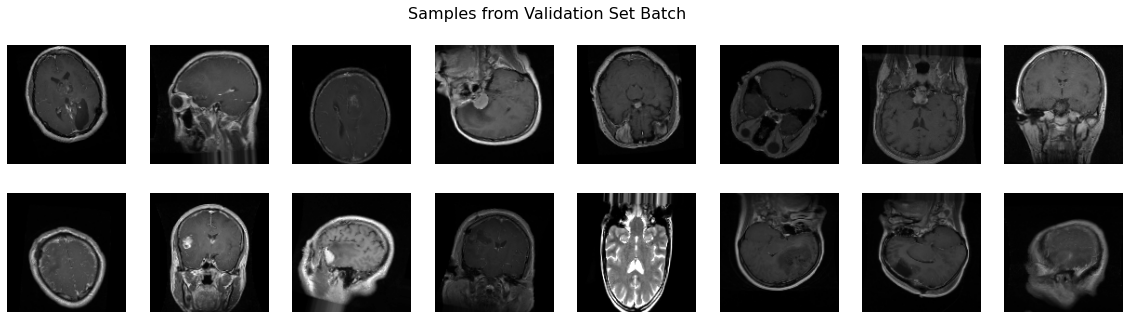

In [31]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)


## Visualising Validating Images


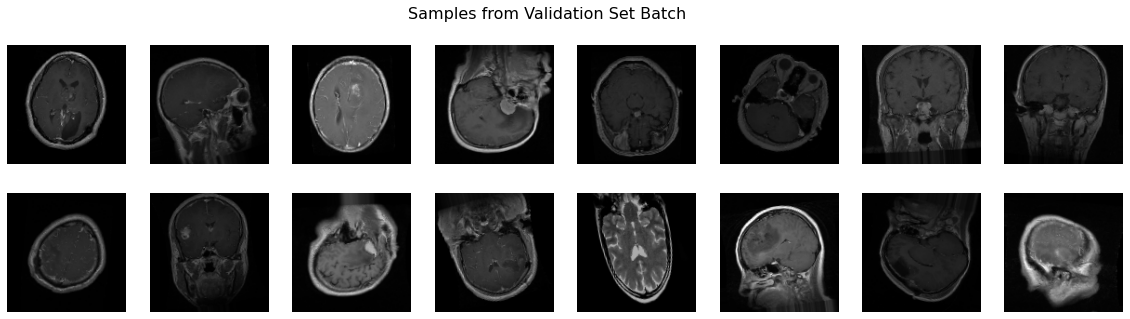

In [32]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Validation Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), validation_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)



> Indented block


## Visualise Testing Images


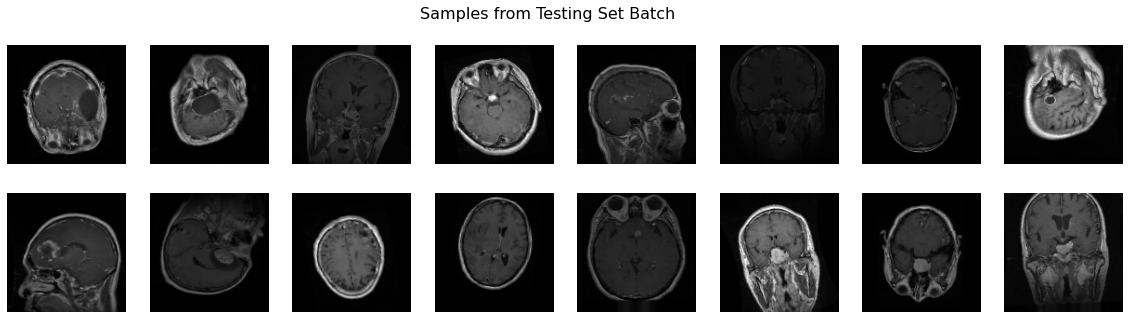

In [33]:
fig, axes = plt.subplots(nrows = 2, ncols = 8, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_dataset[0][0][:16]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)


## Model Development


In [34]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10)

In [35]:
ROOT_CHECKPOINT_DIR_PATH = os.path.join(ROOT_DIR, "Model-Checkpoints")
MLP_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "Multi-Layer-Perceptron")
ALEXNET_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "AlexNet-CNN")
INCEPTIONV3_CHECKPOINT_DIR_PATH = os.path.join(ROOT_CHECKPOINT_DIR_PATH, "InceptionV3")

print(ROOT_CHECKPOINT_DIR_PATH)
print(MLP_CHECKPOINT_DIR_PATH)
print(ALEXNET_CHECKPOINT_DIR_PATH)
print(INCEPTIONV3_CHECKPOINT_DIR_PATH)

/gdrive/MyDrive/NN/Model-Checkpoints
/gdrive/MyDrive/NN/Model-Checkpoints/Multi-Layer-Perceptron
/gdrive/MyDrive/NN/Model-Checkpoints/AlexNet-CNN
/gdrive/MyDrive/NN/Model-Checkpoints/InceptionV3


In [36]:
os.path.isdir(ROOT_CHECKPOINT_DIR_PATH)
os.path.isdir(MLP_CHECKPOINT_DIR_PATH)  
os.path.isdir(ALEXNET_CHECKPOINT_DIR_PATH) 
os.path.isdir(INCEPTIONV3_CHECKPOINT_DIR_PATH)

True

In [37]:
mlp_cp_callback = ModelCheckpoint(MLP_CHECKPOINT_DIR_PATH, 
                                  monitor = 'val_accuracy', 
                                  verbose = 1, 
                                  save_weights_only = True, 
                                  save_freq =  'epoch')

alexnet_cp_callback = ModelCheckpoint(ALEXNET_CHECKPOINT_DIR_PATH, 
                                      monitor = 'val_accuracy', 
                                      verbose = 1, 
                                      save_weights_only = True, 
                                      save_freq = 'epoch')

inceptionv3_cp_callback = ModelCheckpoint(INCEPTIONV3_CHECKPOINT_DIR_PATH, 
                                          monitor = 'val_accuracy', 
                                          verbose = 1, 
                                          save_weights_only = True, 
                                          save_freq = 'epoch')

In [38]:
def training_process_viz(training_stats: pd.DataFrame, **plot_kwargs) -> None:
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    fig.suptitle(plot_kwargs['plot_title'], fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.08)
    for curr_axis, col_name in zip(axes, ['accuracy', 'loss']):
        curr_axis.grid(True, alpha = 0.3)
        curr_axis.set_title(f"Model {col_name}".title(), fontsize = 14)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[col_name], color = 'blue', ax = curr_axis)
        sns.lineplot(x = range(1, 1 + training_stats.shape[0]), y = training_stats[f"val_{col_name}"], color = 'red', ax = curr_axis)
        curr_axis.set_xlabel("Epochs", fontsize = 12)
        curr_axis.set_ylabel(col_name.title(), fontsize = 12)
        curr_axis.tick_params(which = 'major', labelsize = 12)
        curr_axis.legend([col_name.title(), f"validation {col_name}".title()], title = col_name.title())
    fig.tight_layout()
    sns.despine()


In [39]:
def confusion_matrix_viz(model, test_dataset, **plot_kwargs) -> None:
    assert isinstance(model, Sequential)
    model_preds = [np.argmax(curr_row) for curr_row in model.predict(test_dataset)]
    fig, axis = plt.subplots(figsize = (8, 6))
    class_names = ['Glioma', 'Meningioma', 'No-Tumor', 'Pituitary\nTumor']
    sns.heatmap(confusion_matrix(test_dataset.classes, model_preds), fmt="d", annot = True, cmap = plt.cm.Reds, ax = axis)
    axis.set_title(plot_kwargs['plot_title'], fontsize = 14)
    axis.tick_params(which = 'major', labelsize = 12)
    axis.set_xlabel("Pedicted Class", fontsize = 12)
    axis.set_ylabel("Actual Class", fontsize = 12)
    axis.set_xticklabels(class_names, fontdict = dict(fontsize = 12))
    axis.set_yticklabels(class_names, fontdict = dict(fontsize = 12))
    fig.tight_layout()
    sns.despine()

In [40]:
def generate_report(*models, test_dataset, row_indexes) -> pd.DataFrame:
    assert len(models)
    report_df = pd.DataFrame(columns = ['MAE', 'MSE', 'RMSE', 'Loss', 'Accuracy', 'F1-Score'])
    y_hat = test_dataset.classes # y_hat = ground_truth
    for curr_index, curr_model in enumerate(models):
        assert isinstance(curr_model, Sequential)
        curr_model_loss, curr_model_accuracy = curr_model.evaluate(test_dataset)
        y_preds = [np.argmax(curr_preds) for curr_preds in curr_model.predict(test_dataset)]
        report_df.loc[curr_index] = [mean_absolute_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds), mean_squared_error(y_hat, y_preds, squared = False), curr_model_loss, curr_model_accuracy, f1_score(y_hat, y_preds, average = "micro")]
    report_df.index = row_indexes
    return report_df

Hyper-parameters - CNN:
*   the number and size of the kernels in each convolution layer, 
*   the size of the stride,
*   the size of the kernels in the pooling layer





## Experiment 1 - Build MLP


In [41]:
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape = (image_size, image_size, 3), name = 'Flatten-Layer'))
mlp_model.add(Dense(2048, activation = 'relu', name = 'Hidden-Layer-1'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-1'))
mlp_model.add(Dense(1024, activation = 'relu', name = 'Hidden-Layer-2'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-2'))
mlp_model.add(Dense(512, activation = 'relu', name = 'Hidden-Layer-3'))
mlp_model.add(Dropout(rate = 0.2, name = 'Dropout-Layer-3'))
mlp_model.add(Dense(4, activation = 'softmax', name = 'Output-Layer-1'))
mlp_model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Flatten-Layer (Flatten)     (None, 49152)             0         
                                                                 
 Hidden-Layer-1 (Dense)      (None, 2048)              100665344 
                                                                 
 Dropout-Layer-1 (Dropout)   (None, 2048)              0         
                                                                 
 Hidden-Layer-2 (Dense)      (None, 1024)              2098176   
                                                                 
 Dropout-Layer-2 (Dropout)   (None, 1024)              0         
                                                                 
 Hidden-Layer-3 (Dense)      (None, 512)               524800    
                                                                 
 Dropout-Layer-3 (Dropout)   (None, 512)               0

In [42]:
with tf.device(gpu_device_location) if gpu_device_location else tpu_strategy.scope() if tpu_device_location else tf.device(cpu_device_location):
    mlp_train_history = mlp_model.fit(train_dataset,
                                      batch_size = batch_size,
                                      validation_data = validation_dataset,
                                      epochs = 100, 
                                      callbacks = [early_stopping])

Epoch 1/100
61/61 [==============================] - 784s 13s/step - loss: 4.2666 - accuracy: 0.3972 - val_loss: 1.1222 - val_accuracy: 0.5588
Epoch 2/100
61/61 [==============================] - 80s 1s/step - loss: 1.2363 - accuracy: 0.5026 - val_loss: 1.3556 - val_accuracy: 0.4557
Epoch 3/100
61/61 [==============================] - 78s 1s/step - loss: 1.1912 - accuracy: 0.5212 - val_loss: 1.0695 - val_accuracy: 0.5711
Epoch 4/100
61/61 [==============================] - 80s 1s/step - loss: 1.1531 - accuracy: 0.5455 - val_loss: 1.1237 - val_accuracy: 0.5773
Epoch 5/100
61/61 [==============================] - 78s 1s/step - loss: 1.1132 - accuracy: 0.5527 - val_loss: 1.0586 - val_accuracy: 0.5753
Epoch 6/100
61/61 [==============================] - 78s 1s/step - loss: 1.1343 - accuracy: 0.5408 - val_loss: 1.1597 - val_accuracy: 0.4660
Epoch 7/100
61/61 [==============================] - 79s 1s/step - loss: 1.0871 - accuracy: 0.5573 - val_loss: 0.9811 - val_accuracy: 0.6186
Epoch 8/100

In [43]:
mlp_model.save("/gdrive/MyDrive/NN/Model-Checkpoints/Multi-Layer-Perceptron/Multi-Layer-Perceptron_ht100.h5")
print("Saved model to disk")

Saved model to disk


Observation - Validation loss and Validation Accuracy has remained constant during the process

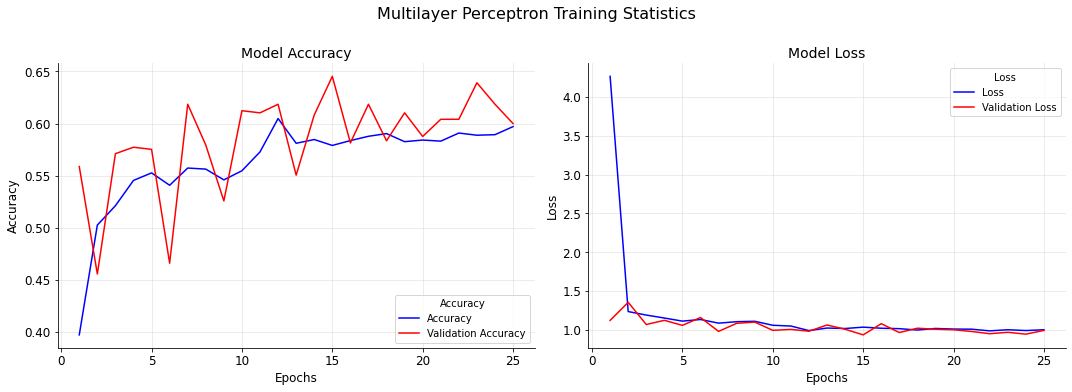

In [44]:
training_process_viz(pd.DataFrame(mlp_train_history.history), 
                     plot_title = 'Multilayer Perceptron Training Statistics')


#8.1.4 Confusion Matrix for Multi-Layer Perceptron Based Model


61/61 [==============================] - 70s 1s/step


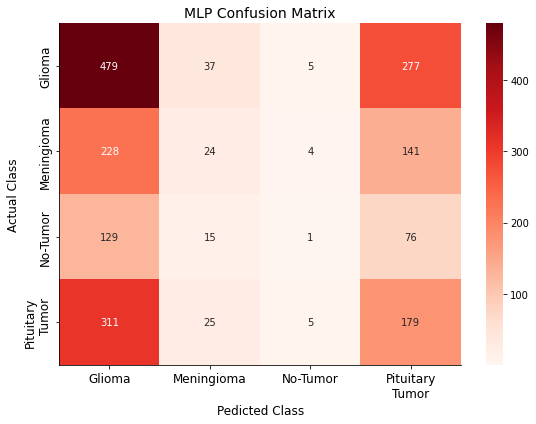

In [45]:
confusion_matrix_viz(mlp_model, train_dataset, plot_title = "MLP Confusion Matrix")

In [46]:
mlp_report_df = generate_report(mlp_model, 
                                test_dataset = test_dataset, 
                                row_indexes = ("Multi-Layer-Perceptron Model",))
mlp_report_df

33/33 [==============================] - 35s 1s/step


,MAE,MSE,RMSE,Loss,Accuracy,F1-Score
Multi-Layer-Perceptron Model,1.399807,3.511561,1.873916,0.976559,0.608863,0.354528


#Adding/Fusing XAI

In [47]:
!pip install lime
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime import lime_image
explainer = lime_image.LimeImageExplainer()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 15.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=98910c6f49d25044ba87eeaa3cbb9e4cc775f85afb1d429570e954036253762a
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [48]:
from skimage import io
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage import transform

from PIL import Image
import numpy as np

url = '/gdrive/MyDrive/NN/Brain_tumour/Testing/test1.jpg'

def read_and_transform_img(url):

    #img = skimage.io.imread(url)
    img =  imread(url, as_gray=False, plugin=None) 
    img = transform.resize(img, (128,128))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img
images = read_and_transform_img(url)

float32
(1, 128, 128, 3)
4


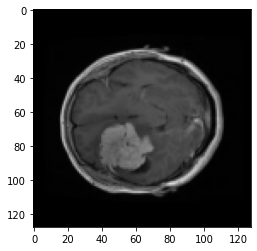

In [49]:
from matplotlib import image
from matplotlib import pyplot

plt.imshow(np.squeeze(images)) 

# summarize shape of the pixel array
print(images.dtype)
print(images.shape)
print(images.ndim)

pyplot.show()

In [50]:
!pip install lime
import lime
from lime import lime_base
from lime import lime_image
from skimage.segmentation import mark_boundaries
from lime import lime_image


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
KERNEL_WIDTH = 1.75
FEATURE_SELECTION= 'lasso_path'
explainer = lime_image.LimeImageExplainer(kernel_width=KERNEL_WIDTH, feature_selection=FEATURE_SELECTION, verbose=True)

In [55]:
explanation = explainer.explain_instance(images[0].astype('double'), mlp_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step
Intercept 0.07404519733894525
Prediction_local [0.09973633]
Right: 0.110920385
Intercept 0.22051025014771936
Prediction_local [0.37160102]
Right: 0.3684552
Intercept 0.4412705249351868
Prediction_local [0.48641211]
Right: 0.49135205


(-0.5, 127.5, 127.5, -0.5)

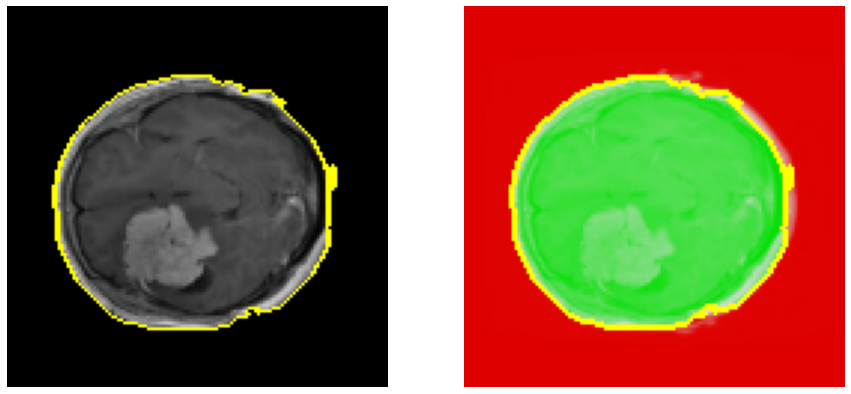

In [56]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

##Load a test image for predictions testing perspective

In [57]:
from skimage import io
from tensorflow.keras.preprocessing import image
from skimage.io import imread
from skimage import transform

from PIL import Image
import numpy as np

url = '/gdrive/MyDrive/NN/Brain_tumour/Testing/test1.jpg'
#im = Image.open(url)

def read_and_transform_img(url):

    #img = skimage.io.imread(url)
    img =  imread(url, as_gray=False, plugin=None) 
    img = transform.resize(img, (128,128))
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    return img
images = read_and_transform_img(url)


float32
(1, 128, 128, 3)
4


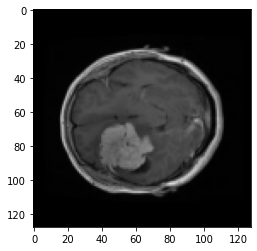

In [58]:
from matplotlib import image
from matplotlib import pyplot
#ata  = images[0].astype('uint8')

plt.imshow(np.squeeze(images)) 

# summarize shape of the pixel array
print(images.dtype)
print(images.shape)
print(images.ndim)


#pyplot.imshow(images)
pyplot.show()

In [62]:
explanation = explainer.explain_instance(images[0].astype('double'), mlp_model.predict,  
                                         top_labels=3, hide_color=0, num_samples=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step
Intercept 0.07409093821955258
Prediction_local [0.09980116]
Right: 0.110920385
Intercept 0.22111562317163286
Prediction_local [0.37062749]
Right: 0.3684552
Intercept 0.44334446642778264
Prediction_local [0.48555306]
Right: 0.49135205


(-0.5, 127.5, 127.5, -0.5)

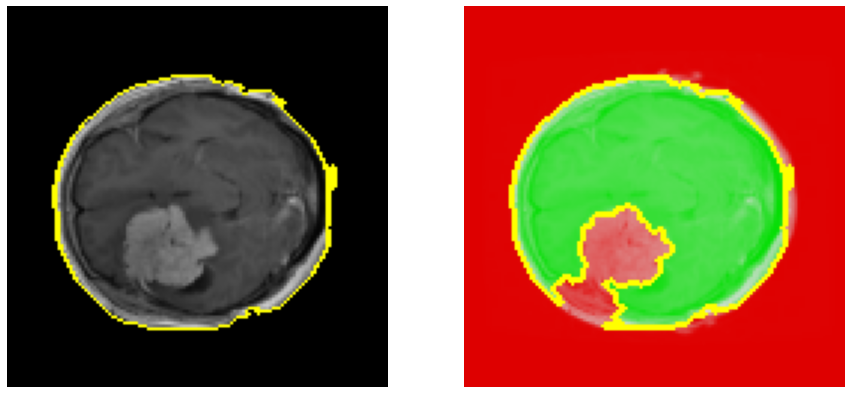

In [ ]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=True, num_features=5, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

#Experiment 2 - 8.2 AlexNet CNN

#Train and validate inception model

In [ ]:
#final_report_df = pd.concat([mlp_report_df, alexnet_report_df, inceptionv3_report_df])
#final_report_df